# DFT-Based Image Watermarking
This notebook demonstrates watermark embedding using Discrete Fourier Transform (DFT), implemented both manually and using OpenCV. It includes image quality evaluation using PSNR, SSIM, RMSE and execution time comparison.

## 1. Import Libraries and Load Image

In this section, we:
- Import necessary libraries for image processing, visualization, and evaluation metrics.
- Load a grayscale image using OpenCV.
- Resize the image to 64x64 for faster computation in subsequent DFT operations.
- Display the resized image using matplotlib.


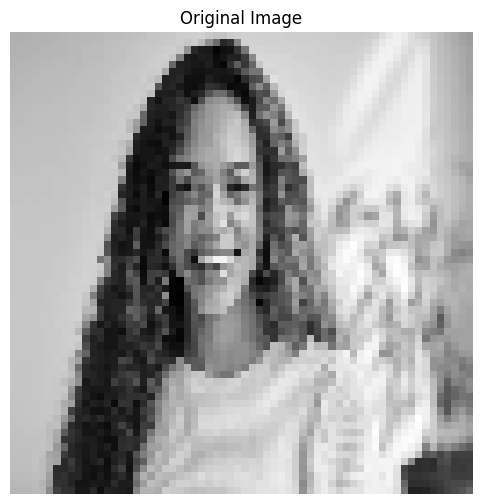

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import time

img = cv2.imread('professional.jpg', cv2.IMREAD_GRAYSCALE)
if img is None:
    raise ValueError("Image not found. Please check the path.")

img_small = cv2.resize(img, (64, 64))
cv2.imwrite('resized.jpg',img_small)

plt.figure(figsize=(12,6))
plt.title("Original Image")
plt.imshow(img_small, cmap='gray')
plt.axis('off')
plt.show()

## 2. Manual DFT-Based Watermarking

This section demonstrates a custom implementation of the 2D Discrete Fourier Transform (DFT) and its inverse (IDFT) to embed a watermark into the frequency domain of an image.

### Key Steps:
- **Custom DFT/IDFT Functions**: Implemented manually to understand the transformation and reconstruction processes.
- **Watermark Creation**: A binary watermark (`v7shinobi`) is added directly to the magnitude spectrum of the DFT.
- **Watermark Embedding**: The watermark is scaled by a factor `alpha` and added to the magnitude while preserving the original phase.
- **Inverse DFT**: Reconstructs the watermarked image using the modified frequency components.
- **Timing**: Measures the time taken for DFT and IDFT operations.

### Visualization:
- **DFT Magnitude** before and after watermark embedding.
- **Watermarked Image** generated from the inverse DFT.
- **Difference Visuals**:
  - DFT magnitude before vs. after.
  - Spatial domain difference between the original and watermarked image.
  - Watermark pattern used.

### Evaluation Metrics:
- **PSNR** and **SSIM** are computed between the original and watermarked image.
- **RMSE** is calculated to measure the reconstruction error.

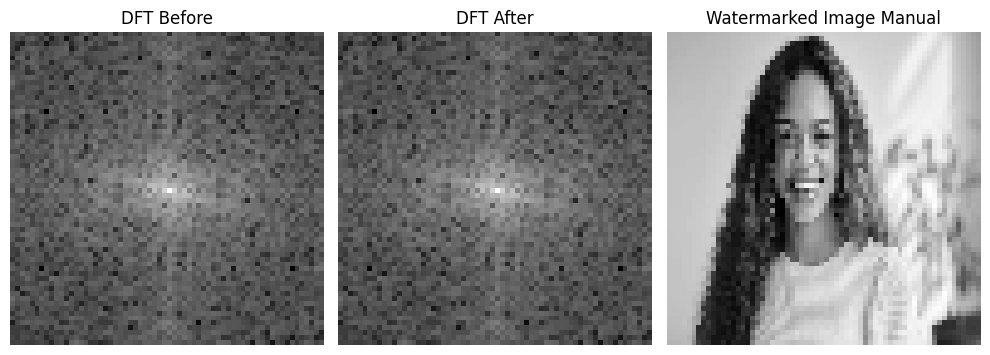

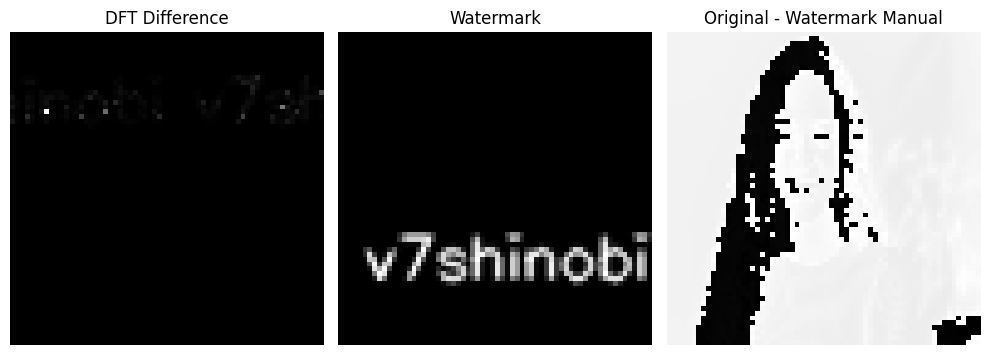

In [2]:
def custom_dft2(image):
    M, N = image.shape
    dft = np.zeros((M, N), dtype=complex)
    for u in range(M):
        for v in range(N):
            sum_val = 0.0
            for x in range(M):
                for y in range(N):
                    angle = -2j * np.pi * ((u * x / M) + (v * y / N))
                    sum_val += image[x, y] * np.exp(angle)
            dft[u, v] = sum_val
    return dft

def custom_idft2(dft):
    M, N = dft.shape
    idft = np.zeros((M, N), dtype=complex)
    for x in range(M):
        for y in range(N):
            sum_val = 0.0
            for u in range(M):
                for v in range(N):
                    angle = 2j * np.pi * ((u * x / M) + (v * y / N))
                    sum_val += dft[u, v] * np.exp(angle)
            idft[x, y] = sum_val / (M * N)
    return np.abs(idft)

start_dft = time.time()
dft_original = custom_dft2(img_small)
end_dft = time.time()
time_dft_manual = end_dft - start_dft

magnitude_orig = np.log1p(np.abs(np.fft.fftshift(dft_original)))
magnitude_norm = cv2.normalize(magnitude_orig, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('DFTbefore_manual.jpg',magnitude_norm)

watermark_manual = np.zeros_like(img_small)
cv2.putText(watermark_manual, 'v7shinobi', (5, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 255, 1, cv2.LINE_AA)
watermark_pattern_manual = cv2.normalize(watermark_manual, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('Watermark_pattern_manual.jpg',watermark_pattern_manual)

alpha = 0.1
magnitude = np.abs(dft_original)
phase = np.angle(dft_original)

magnitude_with_wm = magnitude + alpha * (watermark_manual / 255.0)
dft_modified = magnitude_with_wm * np.exp(1j * phase)

magnitude_modified = np.log1p(np.abs(np.fft.fftshift(dft_modified)))
magnitude_mod_manual = cv2.normalize(magnitude_modified, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('DFTafter_manual.jpg',magnitude_mod_manual)

start_idft = time.time()
img_watermarked = custom_idft2(dft_modified)
end_idft = time.time()
time_idft_manual = end_idft - start_idft

img_watermarked = cv2.normalize(img_watermarked, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('watermarked_manual.jpg',img_watermarked)
watermark = cv2.imread('watermarked_manual.jpg')

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("DFT Before")
plt.imshow(magnitude_orig, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title("DFT After")
plt.imshow(magnitude_modified, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title("Watermarked Image Manual")
plt.imshow(img_watermarked, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

difference_dft_manual = np.abs(magnitude_orig - magnitude_modified)
diff_dft_manual = cv2.normalize(difference_dft_manual, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
difference_image_manual = np.abs(img_small - img_watermarked)
diff_image_manual = cv2.normalize(img_watermarked, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('magnitude_diff_manual.jpg',diff_dft_manual)
cv2.imwrite('spatial_diff_manual.jpg',diff_image_manual)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("DFT Difference")
plt.imshow(difference_dft_manual, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title("Watermark")
plt.imshow(watermark_manual, cmap='gray')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title("Original - Watermark Manual")
plt.imshow(difference_image_manual, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

psnr_manual = psnr(img_small, img_watermarked)
ssim_manual = ssim(img_small, img_watermarked)
rmse_manual = np.sqrt(np.mean((img_small - img_watermarked) ** 2))

## 3. Built-in DFT-Based Watermarking Using OpenCV

This section demonstrates the use of OpenCV's built-in functions to apply DFT-based watermarking on the input image. This method provides an efficient and optimized alternative to the manual implementation.

### Key Steps:
- **DFT and IDFT using OpenCV**: The Discrete Fourier Transform is computed using `cv2.dft` and the inverse transform using `cv2.idft`.
- **Watermark Creation**: A binary watermark (`v7shinobi`) is embedded in the magnitude spectrum.
- **Watermark Embedding**: The watermark is normalized and added to the magnitude component while preserving the original phase.
- **Frequency Manipulation**: After embedding, the modified frequency spectrum is reconstructed and transformed back to the spatial domain using IDFT.
- **Timing**: The time taken to perform the built-in DFT and IDFT operations is recorded.

### Visualization:
- **DFT Magnitude** before and after watermark embedding.
- **Watermarked Image** generated from the inverse DFT.
- **Difference Visuals**:
  - DFT magnitude before vs. after.
  - Spatial domain difference between the original and watermarked image.
  - Watermark pattern used.

### Evaluation Metrics:
- **PSNR** (Peak Signal-to-Noise Ratio): Measures signal quality.
- **SSIM** (Structural Similarity Index): Assesses visual similarity.
- **RMSE** (Root Mean Squared Error): Indicates reconstruction error.


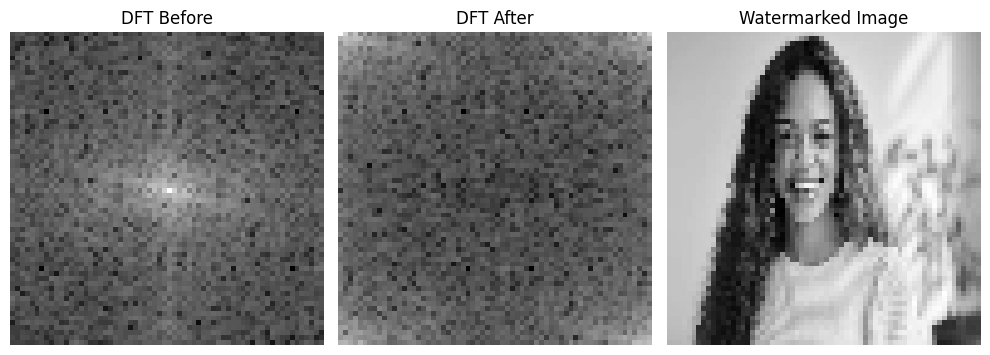

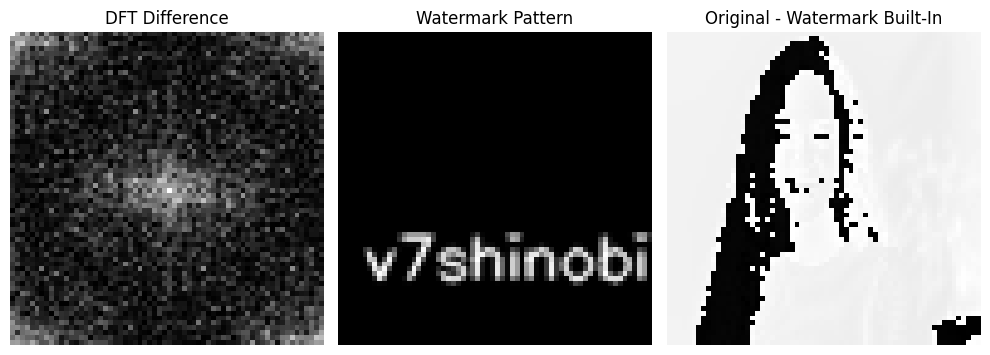

In [3]:
start_dft_b = time.time()
dft = cv2.dft(np.float32(img_small), flags=cv2.DFT_COMPLEX_OUTPUT)
end_dft_b = time.time()
time_dft_b = end_dft_b - start_dft_b

dft_shift = np.fft.fftshift(dft)
magnitude, phase = cv2.cartToPolar(dft_shift[:,:,0], dft_shift[:,:,1])
magnitude_orig = np.log1p(magnitude)
magnitude_norm = cv2.normalize(magnitude_orig, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('DFTbefore_builtin.jpg',magnitude_norm)

watermark_builtin = np.zeros_like(img_small)
cv2.putText(watermark_builtin, 'v7shinobi', (5, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.4, 255, 1, cv2.LINE_AA)
watermark_pattern_builtin = cv2.normalize(watermark_builtin, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('Watermark_pattern_builtin.jpg',watermark_builtin)
watermark_normalized = watermark_builtin / 255.0

alpha = 0.1
magnitude_with_wm = magnitude + alpha * watermark_normalized
real, imag = cv2.polarToCart(magnitude_with_wm.astype(np.float32), phase.astype(np.float32))
dft_modified = np.dstack((real, imag))

dft_ishift = np.fft.ifftshift(dft_modified)
magnitude_modified = cv2.magnitude(dft_ishift[:,:,0], dft_ishift[:,:,1])
magnitude_modified_log = np.log1p(magnitude_modified)
magnitude_mod_builtin = cv2.normalize(magnitude_modified_log, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('DFTafter_builtin.jpg',magnitude_mod_builtin)

start_idft_b = time.time()
img_watermarked_builtin = cv2.idft(dft_ishift)
end_idft_b = time.time()
time_idft_b = end_idft_b - start_idft_b

img_watermarked_builtin = cv2.magnitude(img_watermarked_builtin[:,:,0], img_watermarked_builtin[:,:,1])
img_watermarked_builtin = cv2.normalize(img_watermarked_builtin, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

cv2.imwrite('watermarked_builtin.jpg', img_watermarked_builtin)
watermark_display = cv2.imread('watermarked_builtin.jpg', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("DFT Before")
plt.imshow(magnitude_orig, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("DFT After")
plt.imshow(magnitude_modified_log, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Watermarked Image")
plt.imshow(img_watermarked_builtin, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

difference_dft_builtin = np.abs(magnitude_orig - magnitude_modified_log)
diff_dft_builtin = cv2.normalize(difference_dft_builtin, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
difference_image_builtin = np.abs(img_small - img_watermarked_builtin)
diff_image_builtin = cv2.normalize(difference_image_builtin, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite('magnitude_diff_buitin.jpg',diff_dft_builtin)
cv2.imwrite('spatial_diff_buitin.jpg',diff_image_builtin)

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("DFT Difference")
plt.imshow(difference_dft_builtin, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Watermark Pattern")
plt.imshow(watermark_builtin, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Original - Watermark Built-In")
plt.imshow(difference_image_builtin, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

psnr_builtin = psnr(img_small, img_watermarked_builtin)
ssim_builtin = ssim(img_small, img_watermarked_builtin)
rmse_builtin = np.sqrt(np.mean((img_small - img_watermarked_builtin) ** 2))

## 4. Comparison of Manual vs Built-in DFT Watermarking Methods

This section provides a **side-by-side visual and quantitative comparison** between the manually implemented and OpenCV's built-in DFT watermarking approaches.

### Visual Comparison:
- **Original Grayscale Image**: The input image used for watermark embedding.
- **Watermarked Image (Built-in)**: Result of embedding using OpenCV's built-in DFT and IDFT methods.
- **Watermarked Image (Manual)**: Result from the manually implemented DFT and IDFT process.

### Performance Metrics and Timing:
A DataFrame is generated to compare both methods using:
- **PSNR** (Peak Signal-to-Noise Ratio): Higher is better.
- **SSIM** (Structural Similarity Index): Closer to 1 indicates more similarity.
- **RMSE** (Root Mean Squared Error): Lower values indicate less error.
- **Execution Time (in seconds)** for:
  - Built-in and custom **DFT**
  - Built-in and custom **IDFT**

This provides a comprehensive comparison in terms of **accuracy, quality degradation**, and **computational efficiency**.


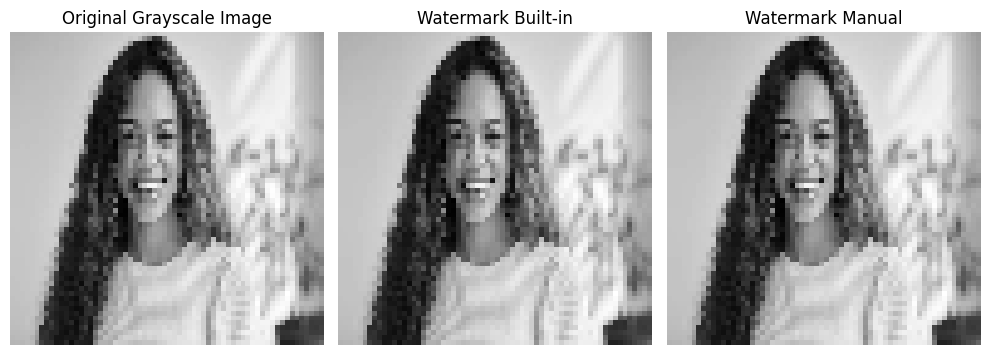

,PSNR Built-in,PSNR Manual,SSIM Built-in,SSIM Manual,RMSE Built-in,RMSE Manual,Time Built-in DFT (s),Time Custom DFT (s),Time Built-in IDFT (s),Time Custom IDFT (s)
Value,26.173881,26.173678,0.9918,0.991801,10.027465,10.02783,0.001014,40.41256,0.0,43.991257


In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_small, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_watermarked_builtin, cmap='gray')
plt.title("Watermark Built-in")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_watermarked, cmap='gray')
plt.title("Watermark Manual")
plt.axis('off')

plt.tight_layout()
plt.show()

data = {
    "PSNR Built-in": [psnr_builtin],
    "PSNR Manual": [psnr_manual],
    "SSIM Built-in": [ssim_builtin],
    "SSIM Manual": [ssim_manual],
    "RMSE Built-in": [rmse_builtin],
    "RMSE Manual": [rmse_manual],
    "Time Built-in DFT (s)": [time_dft_b],
    "Time Custom DFT (s)": [time_dft_manual],
    "Time Built-in IDFT (s)":[time_idft_b],
    "Time Custom IDFT (s)": [time_idft_manual]
}

df = pd.DataFrame(data, index=["Value"])
df.round(4)
df

## 📌 Conclusion

### Summary of Observations:

In this project, we explored and compared two approaches for embedding watermarks into images using the Discrete Fourier Transform (DFT):
- **Manual DFT/IDFT implementation** using nested loops and complex exponentials.
- **Built-in OpenCV DFT/IDFT functions**, which leverage optimized routines for faster execution.

#### Key Observations:
- **Visual Output**: Both manual and built-in methods successfully embedded the watermark without introducing significant visual distortion.
- **Image Quality Metrics**:
  - The **PSNR** and **SSIM** scores between original and watermarked images were very close for both methods, indicating minimal degradation in quality.
  - The **RMSE** values were similarly low, suggesting consistent fidelity between methods.
- **Performance**:
  - The built-in OpenCV functions were **significantly faster**, especially for the inverse DFT.
  - Manual DFT took longer due to its computational complexity (`O(N⁴)`), making it impractical for large images.

### What Went Well:
- Clear demonstration of how watermarking can be embedded and retrieved in the frequency domain.
- Effective visualization of DFT magnitude changes before and after watermarking.
- Proper use of quantitative metrics (PSNR, SSIM, RMSE) for evaluating image quality.
- Captured and compared **execution times**, adding a performance perspective.

### What Could Be Improved:
- **Optimization of Manual DFT**: Although educational, the manual DFT can be optimized using vectorized NumPy operations or parallel processing to reduce execution time.
- **Watermark Robustness Testing**: The study could be extended to test watermark resilience under attacks like cropping, compression, or noise addition.
- **Extraction Process**: While embedding was the focus, implementing and evaluating the watermark extraction accuracy would make the system complete.
- **Color Image Support**: Currently limited to grayscale; extending to RGB images could offer broader applicability.
- **Dynamic Watermark Placement**: Allowing configurable text, font size, and location can make the method more flexible.

---

By combining both manual and built-in methods, this study not only reinforces the understanding of frequency domain processing but also highlights the trade-offs between **theoretical implementation clarity** and **real-world computational efficiency**.
